[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/goosekeeper233/Yelp-Business-Closure-Analysis/blob/main/yelp_business_closure_analysis.ipynb)

# Introduction

In the digital age, online reviews and customer interactions have become pivotal in shaping the success and longevity of businesses across various sectors. As a leading platform for business reviews, Yelp offers a rich dataset that encapsulates consumer sentiments and business attributes. This report delves into the predictive power of Yelp data, aiming to unveil patterns and factors contributing to businesses’ survival and closure. Through advanced data analytics and machine learning techniques, this study harnesses the extensive Yelp dataset to forecast business outcomes and derive actionable insights that can empower business owners and investors to make informed decisions.

## Objectives

The primary objectives of this report are to:
1. Analyze Yelp data to understand the relationship between business statistics and its survival.
2. Employ machine learning models to predict the likelihood of business closures.
3. Offer recommendations based on the analysis to help businesses enhance their operational strategies.

# Data Analysis

Established in 2004, Yelp has become a prominent platform for consumer reviews and business interactions across various industries. Yelp has released an all-purpose learning dataset on its website (https://www.yelp.com/dataset). The Yelp dataset is a subset of its businesses, reviews, and user data for use in connection with academic research. Available as JSON files, it consists of six JSON files, totalling 9.29 GB. In our project, we used the “business.json” and “checkin.json” files, which were the most relevant to our purposes.

Considering the size of the dataset, we use PySpark to process data and train models. PySpark, a Python API for Apache Spark, was chosen for its unparalleled scalability and performance capabilities, which are particularly beneficial when dealing with large-scale datasets like the Yelp database.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop2.tgz
!tar xf spark-3.3.2-bin-hadoop2.tgz

In [ ]:
!pip install -q findspark
from collections import Counter
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop2"

import findspark
findspark.init("spark-3.3.2-bin-hadoop2")# SPARK_HOME

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

sc = SparkContext.getOrCreate()
spark = SparkSession.builder.appName("YelpDataAnalysis").getOrCreate()

The dataset JSON files are read from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
project_root = "/content/drive/My Drive/UVic/CSC 503/Project"
business_data_path = os.path.join(
    project_root, "data", "raw", "yelp_dataset", "yelp_academic_dataset_business.json")
checkin_data_path = os.path.join(
    project_root, "data", "raw", "yelp_dataset", "yelp_academic_dataset_checkin.json")
review_data_path = os.path.join(
    project_root, "data", "raw", "yelp_dataset", "yelp_academic_dataset_review.json")
tip_data_path = os.path.join(
    project_root, "data", "raw", "yelp_dataset", "yelp_academic_dataset_tip.json")
user_data_path = os.path.join(
    project_root, "data", "raw", "yelp_dataset", "yelp_academic_dataset_user.json")

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType, BooleanType, ArrayType, MapType

# Load each dataset
df_business = spark.read.json(business_data_path)
# df_review = spark.read.json(review_data_path)
# df_tip = spark.read.json(tip_data_path)
# df_user = spark.read.json(user_data_path)

In [ ]:
# Print the schema of each DataFrame
df_business.printSchema()
# df_review.printSchema()
# df_tip.printSchema()
# df_user.printSchema()

# Show the first few rows to understand what the data looks like
df_business.show(10)
# df_review.show(10)
# df_tip.show(10)
# df_user.show(10)

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

We start with “business.json,” which contains business data, location data, attributes, and categories. We decided not to use the geographic features because they must be analyzed with an additional dataset; otherwise, making feasible features with only the addresses, latitude, and longitude is impossible. Some numeric features, like “stars” and “review_count,” can be used directly.

In [ ]:
df_business.show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...| Santa Barbara|                null|      0|   34.4266787|  -119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|        Affton|{8:0-18:30, 0:0-0...|      1|   

The “is_open” represents the survival and closure of a business, which is our target. From the histogram, we can see that it's an imbalanced dataset. This means that only a few businesses on Yelp are closed yet.

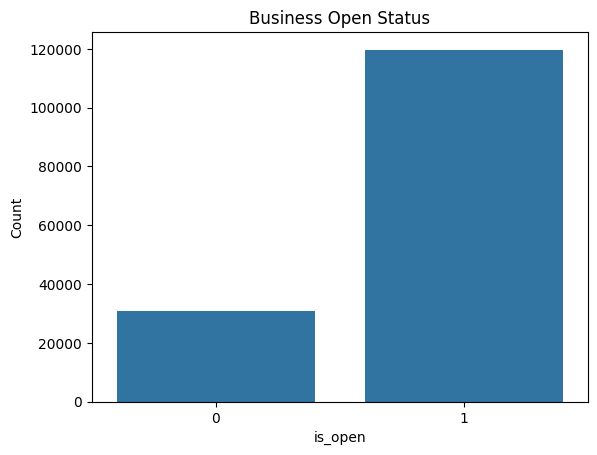

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df_business' is your PySpark DataFrame
is_open_pd = df_business.select("is_open").toPandas()  # Convert to Pandas for Seaborn

sns.countplot(x='is_open', data=is_open_pd)
plt.xlabel("is_open")
plt.ylabel("Count")
plt.title("Business Open Status")
plt.show()

## Categories

In Yelp, a business can be a restaurant, a grocery store or a clinic. They are represented by “categories” in the “business.json” file as an array of strings of business categories. However, for a business, its “categories” are not a classification but like tags, meaning they are not mutually exclusive. For example, a Shoppers Drug Mart can have categories [“Shopping”, “Health & Medical”], and a Quesada Burritos & Tacos can have categories [“Restaurant”, “Food”, “Mexican”, “Fast Food”].

So we implement a function “process_categories(df_business, top=50)”, which finds the top 50 (by default) categories in occurrence as 50 new feature columns, naming “cat_{category_name}” and an extra “cat_Others” feature. For each category tag in one business, if it occurs in one of these top 50, we mark that column to 1 (initial value 0); if it’s not, we increment the count of “cat_Others.”

In [ ]:
from pyspark.sql.functions import col, explode, split, udf
from pyspark.sql.types import MapType, StringType, IntegerType

def process_categories(df_business, top=50):

    # Explode and count categories
    df_exploded = df_business.withColumn("category", explode(split(col("categories"), ",\s*")))
    top_categories = df_exploded.groupBy("category").count().orderBy(col("count").desc()).limit(top)
    top_categories_list = [row['category'] for row in top_categories.collect()]

    # Broadcast the top categories
    broadcast_top_categories = spark.sparkContext.broadcast(top_categories_list)

    # Define UDF to process categories into binary columns and count 'Others'
    def categorize(categories):
        if not categories:
            categories = []
        else:
            categories = categories.split(", ")

        # Initializing dictionary for all categories, setting each to 0
        category_dict = {cat: 0 for cat in broadcast_top_categories.value}
        # Count for categories not in the top list
        others_count = 0

        for category in categories:
            if category in broadcast_top_categories.value:
                category_dict[category] = 1
            else:
                others_count += 1

        category_dict['Others'] = others_count
        return category_dict

    categorize_udf = udf(categorize, MapType(StringType(), IntegerType()))

    # Apply UDF and expand the resulting map to columns
    df_business = df_business.withColumn("category_features", categorize_udf(col("categories")))
    for category in top_categories_list:
        df_business = df_business.withColumn(f"cat_{category}", col("category_features").getItem(category))
    df_business = df_business.withColumn("cat_Others", col("category_features").getItem("Others"))

    # Drop the intermediate column
    df_business = df_business.drop("category_features")

    return df_business


df_business_processed = process_categories(df_business,10)
df_business_processed.show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+---------------+--------+------------+-----------------+-----------------+-------------+--------------------+------------------+--------+--------------+----------+
|             address|          attributes|         business_id|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|cat_Restaurants|cat_Food|cat_Shopping|cat_Home Services|cat_Beauty & Spas|cat_Nightlife|cat_Health & Medical|cat_Local Services|cat_Bars|cat_Automotive|cat_Others|
+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+---------------+--------

In our project, we set the top 20 categories, and the occurrences distribution histogram is shown below.

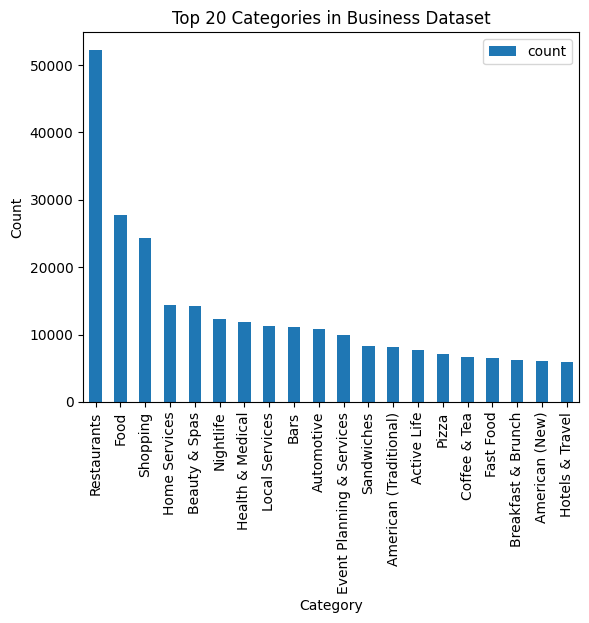

In [ ]:
# Find the top 20 categories
top_categories = df_business.select(explode(split(col("categories"), ",\s*"))).groupBy("col").count().orderBy(col("count").desc()).limit(20)

# Create a bar chart
top_categories.toPandas().plot(kind="bar", x="col", y="count")
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Top 20 Categories in Business Dataset")
plt.xticks(rotation=90)
plt.show()


## Business Hours

The business hours are an object of key day-to-value hours; hours are using a 24-hour clock in JSON. We implement a function “def process_business_hours(df_business)” to extract several features from this object. It converts the time string. To reduce the complexity, we simplified the differences between days but kept the difference between weekdays and weekends. Our defined features are:

1. open_early: the business has at least a day a week open before 6 AM.
2. close_day: the business has at least a day in a week close after 10 PM.
3. operating_days: open days count in a week.
4. weekday_hours: total business time on weekdays (count in minutes)
5. weekend_hours: total business time on weekends (count in minutes)

In [ ]:
from pyspark.sql.functions import col, expr, udf, when

def process_business_hours(df_business):
    df = df_business.select(
        "business_id",
        "name",
        col("hours.Monday").alias("Monday"),
        col("hours.Tuesday").alias("Tuesday"),
        col("hours.Wednesday").alias("Wednesday"),
        col("hours.Thursday").alias("Thursday"),
        col("hours.Friday").alias("Friday"),
        col("hours.Saturday").alias("Saturday"),
        col("hours.Sunday").alias("Sunday")
    )

    # Define the schema for the UDF return type
    result_schema = StructType([
        StructField("closing_minutes", IntegerType(), True),
        StructField("opening_minutes", IntegerType(), True)
    ])

    # Define UDF to calculate minutes from time strings, treating '0:0-0:0' as null
    def get_minutes(time_str):
        if time_str and time_str != "0:0-0:0":
            parts = time_str.split('-')
            if len(parts) == 2:
                open_time, close_time = parts
                open_hour, open_minute = map(int, open_time.split(':'))
                close_hour, close_minute = map(int, close_time.split(':'))
                if close_hour < open_hour or (close_hour == open_hour and close_minute < open_minute):
                    close_hour += 24
                return {"closing_minutes": close_hour * 60 + close_minute, "opening_minutes": open_hour * 60 + open_minute}
        return {"closing_minutes": None, "opening_minutes": None}

    get_minutes_udf = udf(get_minutes, result_schema)

    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    # Apply UDF to get opening and closing minutes for each day
    for day in days:
        df = df.withColumn(f"{day}_times", get_minutes_udf(col(day)))
        df = df.withColumn(f"{day}_closing_minutes", col(f"{day}_times").getField("closing_minutes"))
        df = df.withColumn(f"{day}_opening_minutes", col(f"{day}_times").getField("opening_minutes"))

    # Overall check if all days are null
    all_days_null_check = " AND ".join([f"{day}_times IS NULL" for day in days])

    # Calculate "open_early" and "close_late"
    open_early_expr = " OR ".join([f"{day}_opening_minutes <= 360" for day in days])
    close_late_expr = " OR ".join([f"{day}_closing_minutes >= 1320" for day in days])
    df = df.withColumn("open_early", when(expr(all_days_null_check), lit(None)).otherwise(expr(open_early_expr)))
    df = df.withColumn("close_late", when(expr(all_days_null_check), lit(None)).otherwise(expr(close_late_expr)))

    # Calculate "operating_days"
    operating_days_expr = " + ".join([f"IF({day}_opening_minutes IS NOT NULL, 1, 0)" for day in days])
    df = df.withColumn("operating_days", when(expr(all_days_null_check), lit(None)).otherwise(expr(operating_days_expr)))

    # Calculate "weekday_hours" and "weekend_hours"
    weekday_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
    weekend_days = ["Saturday", "Sunday"]
    weekday_hours_expr = " + ".join([f"COALESCE({day}_closing_minutes - {day}_opening_minutes, 0)" for day in weekday_days])
    weekend_hours_expr = " + ".join([f"COALESCE({day}_closing_minutes - {day}_opening_minutes, 0)" for day in weekend_days])
    df = df.withColumn("weekday_hours", when(expr(all_days_null_check), lit(None)).otherwise(expr(weekday_hours_expr)))
    df = df.withColumn("weekend_hours", when(expr(all_days_null_check), lit(None)).otherwise(expr(weekend_hours_expr)))

    # Cleanup columns
    df = df.drop(*[f"{day}_times" for day in days], *[f"{day}_closing_minutes" for day in days], *[f"{day}_opening_minutes" for day in days])

    # Check open_early and close_late columns, if null make it false
    df = df.withColumn("open_early", when(df["open_early"].isNull(), False).otherwise(df["open_early"]))
    df = df.withColumn("close_late", when(df["close_late"].isNull(), False).otherwise(df["close_late"]))

    # Check if all days are null, if so, make the following columns null
    all_days_null_check = " AND ".join([f"{day} IS NULL" for day in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]])
    df = df.withColumn("open_early", when(expr(all_days_null_check), None).otherwise(df["open_early"]))
    df = df.withColumn("close_late", when(expr(all_days_null_check), None).otherwise(df["close_late"]))
    df = df.withColumn("operating_days", when(expr(all_days_null_check), None).otherwise(df["operating_days"]))
    df = df.withColumn("weekday_hours", when(expr(all_days_null_check), None).otherwise(df["weekday_hours"]))
    df = df.withColumn("weekend_hours", when(expr(all_days_null_check), None).otherwise(df["weekend_hours"]))

    # drop columns "name" and Monday to Sunday
    df = df.drop("name")
    for day in days:
        df = df.drop(day)

    df_joined = df_business.join(df, on="business_id", how="inner")

    return df_joined


df_business_processed = process_business_hours(df_business_processed)
df_business_processed.show()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+---------------+--------+------------+-----------------+-----------------+-------------+--------------------+------------------+--------+--------------+----------+----------+----------+--------------+-------------+-------------+
|         business_id|             address|          attributes|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|cat_Restaurants|cat_Food|cat_Shopping|cat_Home Services|cat_Beauty & Spas|cat_Nightlife|cat_Health & Medical|cat_Local Services|cat_Bars|cat_Automotive|cat_Others|open_early|close_late|operating_days|weekday_hours|weekend_hours|
+--------------------+--------------------+--------------------+--------------------+--------------+----------

Some businesses have a null or several in their business schedule; we believe this represents they are closed on that day; in this case, that day will be counted as 0 in the hours count. Some businesses have all schedules as null, meaning their business time is missing. The “process_business_hours” also keeps all null in the extracted feature, which can be imputed later in the model training.

In [ ]:
from pyspark.sql.functions import col, when

df_transformed = df_business_processed.withColumn(
    "open_early",
    when(col("open_early").isNull(), "Unknown")  # Mark nulls as 'Unknown'
    .otherwise(when(col("open_early"), 1).otherwise(0))  # Convert true/false to 1/0
)

df_transformed = df_transformed.withColumn(
    "close_late",
    when(col("close_late").isNull(), "Unknown")  # Mark nulls as 'Unknown'
    .otherwise(when(col("close_late"), 1).otherwise(0))  # Convert true/false to 1/0
)

In [ ]:
pandas_df = df_transformed.toPandas()

Below is the histogram of “open_early” and “close_day”, we can see that very few businesses open early in the morning, while some close late at night.

<ipython-input-14-68c6f72aaaa9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=pandas_df, palette='viridis', order=[0, 1, "Unknown"])


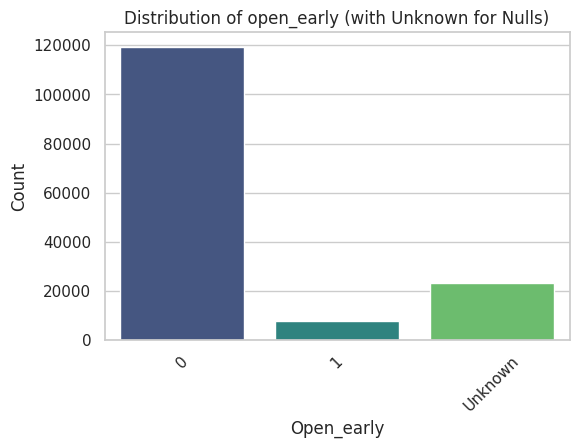

<ipython-input-14-68c6f72aaaa9>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=column, data=pandas_df, palette='viridis', order=[0, 1, "Unknown"])


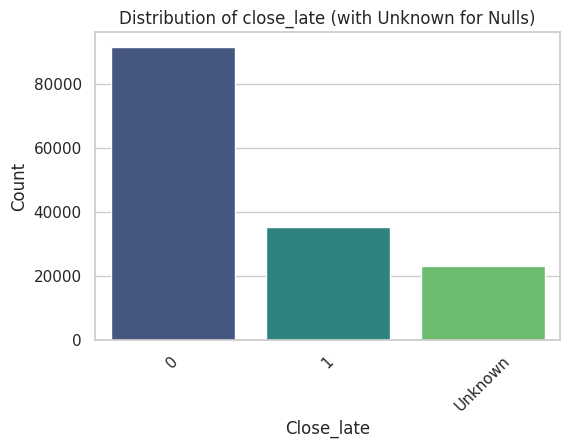

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Plot each binary column
for column in ['open_early', 'close_late']:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=column, data=pandas_df, palette='viridis', order=[0, 1, "Unknown"])
    plt.title(f'Distribution of {column} (with Unknown for Nulls)')
    plt.ylabel('Count')
    plt.xlabel(column.capitalize())
    plt.xticks(rotation=45)  # Rotate labels if needed
    plt.show()


In [ ]:
from pyspark.sql.functions import mean, col

# Calculate mean or median to fill nulls
mean_values = df_business_processed.select(
    [mean(col(c)).alias(c) for c in ['operating_days', 'weekday_hours', 'weekend_hours']]
).collect()[0]

# Fill nulls
df_filled = df_business_processed.fillna({
    'operating_days': mean_values['operating_days'],
    'weekday_hours': mean_values['weekday_hours'],
    'weekend_hours': mean_values['weekend_hours']
})

df_filled = df_filled.select('operating_days', 'weekday_hours', 'weekend_hours')


Below is the distribution of “operating_days,” “weekday_hours,” and “weekend_hours.” We can see that many businesses don't open on weekends.

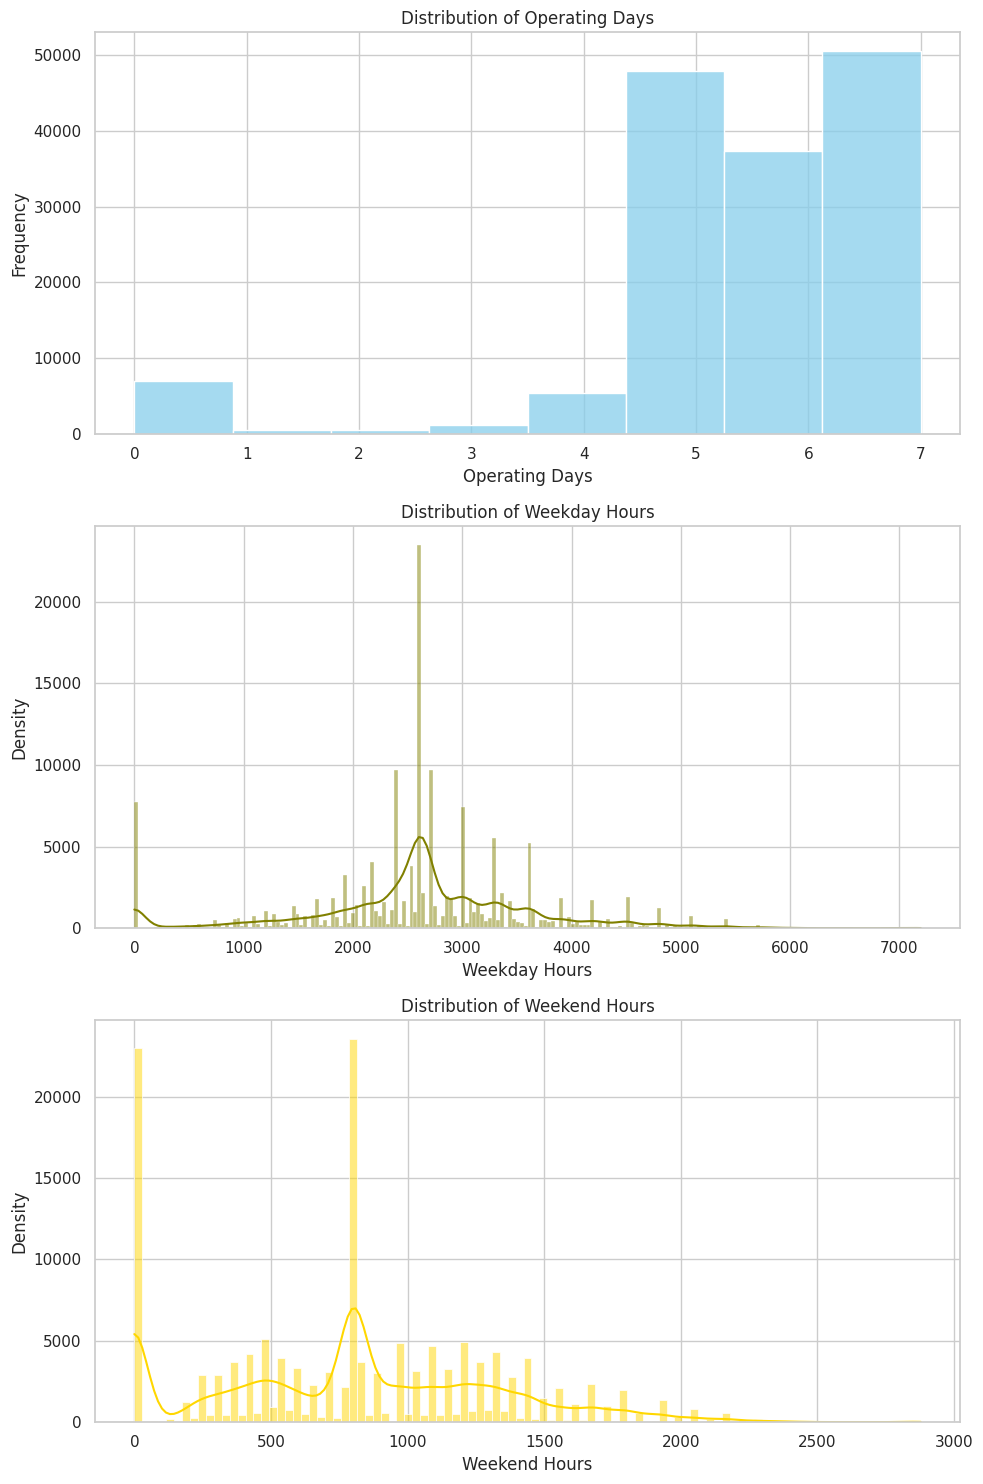

In [ ]:
pandas_df = df_filled.toPandas()

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Create histograms or density plots
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for operating_days
sns.histplot(pandas_df['operating_days'], bins=8, kde=False, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Operating Days')
axes[0].set_xlabel('Operating Days')
axes[0].set_ylabel('Frequency')

# Plot for weekday_hours
sns.histplot(pandas_df['weekday_hours'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Distribution of Weekday Hours')
axes[1].set_xlabel('Weekday Hours')
axes[1].set_ylabel('Density')

# Plot for weekend_hours
sns.histplot(pandas_df['weekend_hours'], kde=True, ax=axes[2], color='gold')
axes[2].set_title('Distribution of Weekend Hours')
axes[2].set_xlabel('Weekend Hours')
axes[2].set_ylabel('Density')

plt.tight_layout()
plt.show()


## Checkin

For Yelp, check-ins are a way to keep track of the local businesses people visit and keep their friends updated on your latest comings and goings. It is the closest measure of visiting records in the Yelp dataset. In the “checkin.json,” each JSON object is the check-in record for a business, uniquely identified by the “business_id” and recorded in “date,” a string which is a comma-separated list of timestamps for each check-in, each with format YYYY-MM-DD HH:MM:SS.

In [ ]:
df_checkin = spark.read.json(checkin_data_path)
df_checkin.printSchema()
df_checkin.show(10)

root
 |-- business_id: string (nullable = true)
 |-- date: string (nullable = true)

+--------------------+--------------------+
|         business_id|                date|
+--------------------+--------------------+
|---kPU91CF4Lq2-Wl...|2020-03-13 21:10:...|
|--0iUa4sNDFiZFrAd...|2010-09-13 21:43:...|
|--30_8IhuyMHbSOcN...|2013-06-14 23:29:...|
|--7PUidqRWpRSpXeb...|2011-02-15 17:12:...|
|--7jw19RH9JKXgFoh...|2014-04-21 20:42:...|
|--8IbOsAAxjKRoYsB...|2015-06-06 01:03:...|
|--9osgUCSDUWUkoTL...|2015-06-13 02:00:...|
|--ARBQr1WMsTWiwOK...|2014-12-12 00:44:...|
|--FWWsIwxRwuw9vIM...|2010-09-11 16:28:...|
|--FcbSxK1AoEtEAxO...|2017-08-18 19:43:...|
+--------------------+--------------------+
only showing top 10 rows



This means we can infer a business's popularity (on Yelp). Moreover, we can also guess a business's open date by finding the first check-in record. If a business is closed, we can find the last record as the approximate close date. So we can find if a business survived through Covid.

So we designed a “process_checkins(df_checkin)” that extracts the below features:

1. total_checkins: Total check-in counts.
2. first_before_covid: If the first check-in is before Covid (Mar 2020)
3. last_after_covid: If the last check-in is after the Covid era (Jan 2022)

In [ ]:
from pyspark.sql.functions import col, explode, split, to_timestamp, min, max, count, lit

def process_checkins(df_checkin):
    # Explode the date string into individual timestamp entries
    df_checkin = df_checkin.withColumn("timestamp", explode(split(col("date"), ",\s*")))
    df_checkin = df_checkin.withColumn("timestamp", to_timestamp(col("timestamp"), "yyyy-MM-dd HH:mm:ss"))

    # Aggregate to find the first and last check-in times and count total check-ins
    df_checkin_agg = df_checkin.groupBy("business_id").agg(
        min("timestamp").alias("first_checkin"),
        max("timestamp").alias("last_checkin"),
        count("timestamp").alias("total_checkins")
    )

    # Define the COVID threshold date
    covid_start_date = to_timestamp(lit("2020-03-01 00:00:00"), "yyyy-MM-dd HH:mm:ss")
    covid_end_date = to_timestamp(lit("2022-01-01 00:00:00"), "yyyy-MM-dd HH:mm:ss")

    # Add columns to check if the first check-in is before COVID and the last check-in is after COVID
    df_checkin_agg = df_checkin_agg.withColumn(
        "first_before_covid", (col("first_checkin") < covid_start_date)
    ).withColumn(
        "last_after_covid", (col("last_checkin") > covid_end_date)
    )

    return df_checkin_agg


df_checkin_processed = process_checkins(df_checkin)
df_checkin_processed.show()

+--------------------+-------------------+-------------------+--------------+------------------+----------------+
|         business_id|      first_checkin|       last_checkin|total_checkins|first_before_covid|last_after_covid|
+--------------------+-------------------+-------------------+--------------+------------------+----------------+
|-0iIxySkp97WNlwK6...|2015-07-01 18:39:21|2021-12-24 19:18:53|           449|              true|           false|
|-1dARtemb2Gy7Xlft...|2014-02-17 20:43:22|2014-06-01 14:15:08|             2|              true|           false|
|-BB9Xn-ak_23FxVEW...|2016-01-30 21:46:59|2019-08-18 22:05:34|             2|              true|           false|
|-JAwNIEJoDXmdE_8s...|2012-07-06 12:30:48|2019-04-05 23:28:49|           360|              true|           false|
|-UADx0eR5Huq6s1CP...|2015-02-12 21:37:35|2016-09-22 01:08:55|            20|              true|           false|
|-WUHfRZ7a5NQA4TyG...|2017-12-21 18:56:56|2020-10-21 14:36:36|             2|           

## Combing

The business-based features and check-in-based features are extracted from two JSON files and can be combined by the same business_id; we used an inner join here.

In [ ]:
df_combined = df_business_processed.join(df_checkin_processed, on="business_id", how="inner")
df_combined.show()

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+---------------+--------------------+-----------+------------+-----+-----+---------------+--------+------------+-----------------+-----------------+-------------+--------------------+------------------+--------+--------------+----------+----------+----------+--------------+-------------+-------------+-------------------+-------------------+--------------+------------------+----------------+
|         business_id|             address|          attributes|          categories|         city|               hours|is_open|     latitude|      longitude|                name|postal_code|review_count|stars|state|cat_Restaurants|cat_Food|cat_Shopping|cat_Home Services|cat_Beauty & Spas|cat_Nightlife|cat_Health & Medical|cat_Local Services|cat_Bars|cat_Automotive|cat_Others|open_early|close_late|operating_days|weekday_hours|weekend_hours|      first_checkin|

## Correlation

We can get some preliminary guesses from the correlation matrix.

1. Covid has the most significant impact on the survival of the business.
2. A business closing late at night or having more business hours on weekends is more likely to close. This might be because of the high labour cost.

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.sql import DataFrame

def impute_binary_columns(df: DataFrame, column_names: list) -> DataFrame:
    """
    Imputes binary columns by replacing nulls with False.
    Converts true/false to 1/0.
    """
    for column_name in column_names:
        # Replace nulls with False and convert true/false to 1/0
        df = df.withColumn(column_name,
                           when(col(column_name).isNull(), False).otherwise(col(column_name)))
        df = df.withColumn(column_name, col(column_name).cast("integer"))

    return df

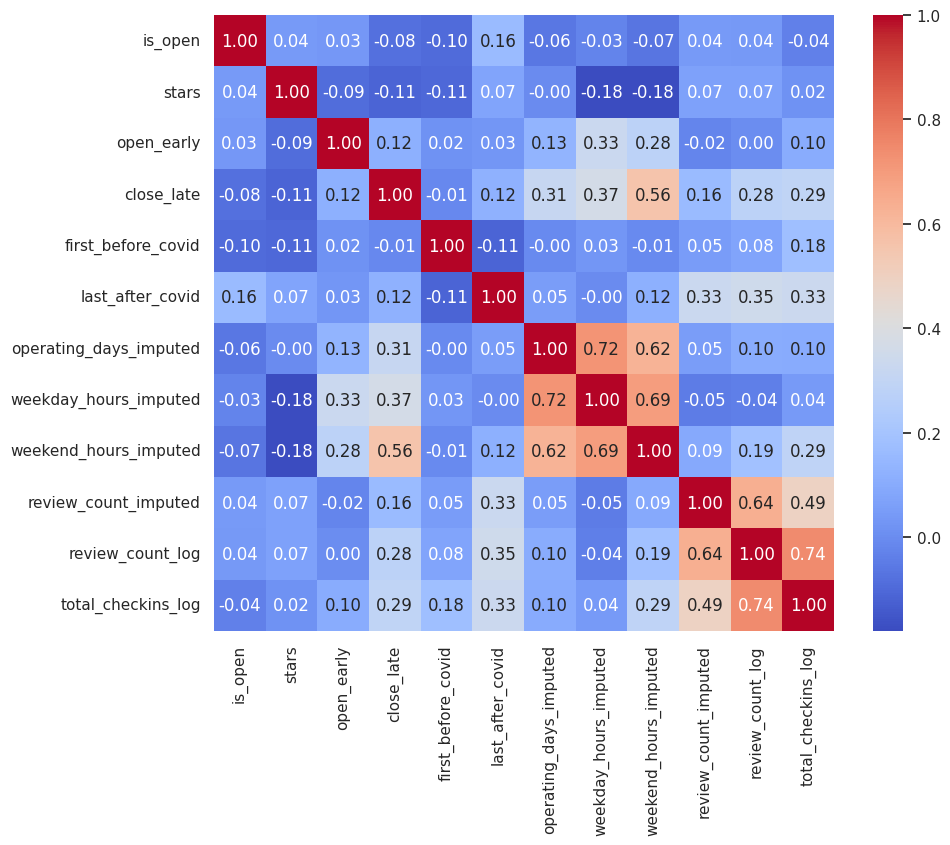

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_combined is already loaded
df_corr = df_combined.select(
    "is_open",
    "review_count",
    "stars",
    "open_early",
    "close_late",
    "operating_days",
    "weekday_hours",
    "weekend_hours",
    "total_checkins",
    "first_before_covid",
    "last_after_covid",
)

binary_columns = ['open_early', 'close_late', 'first_before_covid', 'last_after_covid']
df_corr = impute_binary_columns(df_corr, binary_columns)  # ensure this function handles datatype conversion

imputer = Imputer(
    inputCols=["operating_days", "weekday_hours", "weekend_hours", "review_count"],
    outputCols=["operating_days_imputed", "weekday_hours_imputed", "weekend_hours_imputed", "review_count_imputed"],
    strategy="mean"
)
df_corr_imputed = imputer.fit(df_corr).transform(df_corr)

df_corr_imputed = df_corr_imputed.withColumn("review_count_log", log1p("review_count"))
df_corr_imputed = df_corr_imputed.withColumn("total_checkins_log", log1p("total_checkins"))

df_corr_imputed = df_corr_imputed.drop('operating_days', 'weekday_hours', 'weekend_hours', 'review_count', 'total_checkins')

# Calculate correlation matrix for all numerical columns
corr_matrix = df_corr_imputed.toPandas().corr()  # Convert to Pandas DataFrame for compatibility with seaborn

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", ax=ax, cmap="coolwarm")

# Display plot
plt.show()

# Training using PySpark

In this project, our purpose is to predict whether a business is closed (0 as false), or still operating (1 as true). This is obviously a binary classification problem, and we need to determine which attributes are most useful for our task. We first want to complete our training using PySpark, so it can be compatible with a larger dataset, such as the full Yelp dataset. Currently, we are just working on a subset of the original collection. As the dataset updates, more samples can increase the performance of the model and help us identify those independent attributes that have a high correlation with the prediction. In conclusion, we believe it is worthwhile to try PySpark.

## Coding Section:

`evaluate_model()`
this function will do the prediction with provided test_data and model, print out the comfusion matrix, AUC_ROC, AUC_PR,precision, recall, accuracy

`impute_binary_column()`
this function will replace null value from bool to false; and then change the attribute of bool to 0 and 1; indicating false and true

### Methodology, First Experiment:

**Features**:

'open_early', 'close_late', 'first_before_covid', 'last_after_covid','operating_days', 'weekday_hours', 'weekend_hours', 'review_count', 'stars', 'total_checkins'

**Label**:

'is_open'

**Preprocessing**:

replace null value from bool to false; and then change the attribute of bool to 0 & 1.

Replace all missing numerical number with their mean.
Scale necessary numerical number

Vectorizing features so it can be used for training using pyspark.

**Training**:

We tested Linear Regression, Random Forest and SVM.

Result:In the first experiment, our recall is 1 and precision is about 70%. It looks good, but when we checked the confusion matrix, we found that the prediction of false (closed) is near to 0. This means our algorithm is working like a dummy classifier that always predicts true.

Our dataset is unbalanced, having about 70% true labels and 30% false labels. We realized the unbalanced dataset is overwhelming our model, so we decided to handle the unbalanced dataset and conducted a second experiment. This time, we want to maintain a high recall and significantly increase the precision.

We decided to use **SMOTE**, which is designed for unbalanced datasets; however, it is not available for PySpark. Therefore, we simply duplicated the closed cases (is_open = false), hoping for a similar result.

For the second time, we obtained our results in the following printout. The random forest may be considered the best among the three; however, both precision and recall are unacceptable. Therefore, we conducted another experiment using DataFrame to prove the correctness of our idea.



In [ ]:
from pyspark.sql.functions import col, sum as sql_sum, when, lit
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.sql import DataFrame


def evaluate_model(model, test_data, omit_auc=False):
    print("Model Evaluation:")

    # Make predictions on the test data
    predictions = model.transform(test_data)

    # Calculate confusion matrix elements
    tp = sql_sum(when((col('is_open') == 1) & (col('prediction') == 1), 1).otherwise(0)).alias('tp')
    tn = sql_sum(when((col('is_open') == 0) & (col('prediction') == 0), 1).otherwise(0)).alias('tn')
    fp = sql_sum(when((col('is_open') == 0) & (col('prediction') == 1), 1).otherwise(0)).alias('fp')
    fn = sql_sum(when((col('is_open') == 1) & (col('prediction') == 0), 1).otherwise(0)).alias('fn')

    # Perform a single aggregation to calculate all four metrics
    metrics = predictions.agg(tp, tn, fp, fn).collect()[0]
    tp_val, tn_val, fp_val, fn_val = metrics['tp'], metrics['tn'], metrics['fp'], metrics['fn']

    if not omit_auc:
        # Evaluate the model using AUC-ROC and AUC-PR
        evaluatorROC = BinaryClassificationEvaluator(labelCol="is_open", rawPredictionCol="probability", metricName="areaUnderROC")
        evaluatorPR = BinaryClassificationEvaluator(labelCol="is_open", rawPredictionCol="probability", metricName="areaUnderPR")
        auc_roc = evaluatorROC.evaluate(predictions)
        auc_pr = evaluatorPR.evaluate(predictions)
        print(f"AUC-ROC: {auc_roc}\nAUC-PR: {auc_pr}")

    # Calculate precision, recall, and accuracy
    precision = tp_val / (tp_val + fp_val) if (tp_val + fp_val) != 0 else 0
    recall = tp_val / (tp_val + fn_val) if (tp_val + fn_val) != 0 else 0
    accuracy = (tp_val + tn_val) / (tp_val + tn_val + fp_val + fn_val)

    # Print evaluation metrics, confusion matrix, and AUC
    print(f"Confusion Matrix:\n[[{tn_val}, {fp_val}],\n [{fn_val}, {tp_val}]]")
    print(f"Precision: {precision}\nRecall: {recall}\nAccuracy: {accuracy}")

    print("-" * 50)

In [ ]:
from pyspark.sql.functions import col

# Assuming class 0 is the minority
minority_df = df_combined.filter(col('is_open') == 0)
majority_df = df_combined.filter(col('is_open') == 1)

# Calculate the ratio needed to balance the classes
ratio = majority_df.count() / minority_df.count()

# Duplicate minority class rows
oversampled_minority_df = minority_df.sample(withReplacement=True, fraction=ratio)

# Combine the oversampled minority class with the majority class
df_balanced = majority_df.union(oversampled_minority_df)

In [ ]:
df_combined.count()

131930

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import log1p


# df = df_combined
df = df_balanced

binary_columns = ['open_early', 'close_late', 'first_before_covid', 'last_after_covid']
df = impute_binary_columns(df, binary_columns)

df = df.withColumn("review_count_log", log1p("review_count"))
df = df.withColumn("total_checkins_log", log1p("total_checkins"))


# Impute missing values for numerical features
imputer = Imputer(
    inputCols=["operating_days", "weekday_hours", "weekend_hours", "review_count_log", "stars", "total_checkins_log"],
    outputCols=["operating_days_imputed", "weekday_hours_imputed", "weekend_hours_imputed", "review_count_log_imputed", "stars_imputed", "total_checkins_log_imputed"],
    strategy="mean"
)

# Assemble numerical features for scaling
num_assembler = VectorAssembler(
    inputCols=["operating_days_imputed", "weekday_hours_imputed", "weekend_hours_imputed", "review_count_log_imputed", "stars_imputed"],
    outputCol="numerical_features"
)

# Scale the numerical features
scaler = StandardScaler(inputCol="numerical_features", outputCol="scaled_features")

# Combine scaled numerical features with binary features
total_assembler = VectorAssembler(
    inputCols=["open_early", "close_late", "first_before_covid", "last_after_covid", "scaled_features"],
    outputCol="features"
)

In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.regression import GBTRegressor


# Define the classifier
lr = LogisticRegression(featuresCol='features', labelCol='is_open')
rf = RandomForestClassifier(featuresCol='features', labelCol='is_open')
svm = LinearSVC(featuresCol='features', labelCol='is_open')

# Build the pipeline
pipeline_lr = Pipeline(stages=[imputer, num_assembler, scaler, total_assembler, lr])
pipeline_rf = Pipeline(stages=[imputer, num_assembler, scaler, total_assembler, rf])
pipeline_svm = Pipeline(stages=[imputer, num_assembler, scaler, total_assembler, svm])

# Split the data into training and testing sets
train_data, test_data = df.randomSplit([0.7, 0.3], seed=42)


# Train the model
model_lr = pipeline_lr.fit(train_data)
evaluate_model(model_lr, test_data)

model_rf = pipeline_rf.fit(train_data)
evaluate_model(model_rf, test_data)

model_svm = pipeline_svm.fit(train_data)
evaluate_model(model_svm, test_data, omit_auc=True)

Model Evaluation:
AUC-ROC: 0.6535543202402937
AUC-PR: 0.697792987942788
Confusion Matrix:
[[22305, 8581],
 [15381, 15416]]
Precision: 0.6424136350377131
Recall: 0.5005682371659578
Accuracy: 0.611529919102508
--------------------------------------------------
Model Evaluation:
AUC-ROC: 0.6965563591404891
AUC-PR: 0.7248542897828731
Confusion Matrix:
[[24817, 6069],
 [16555, 14242]]
Precision: 0.7011963960415538
Recall: 0.4624476410039939
Accuracy: 0.6332214710698247
--------------------------------------------------
Model Evaluation:
Confusion Matrix:
[[25246, 5640],
 [17434, 13363]]
Precision: 0.7032047571436089
Recall: 0.4339058999253174
Accuracy: 0.6259261060583954
--------------------------------------------------


# Training using Pandas and scikit-learn

In this section, we followed the same steps as we did in the PySpark section; however, this time we took only 0.2 fraction of the original dataset using stratified sampling (sample by uses stratified sampling by default), and we applied the **SMOTE** function. The result is displayed at the end of the code.

To achieve our goal of increasing precision and maintaining a good recall rate, we focused on the confusion matrix. As we can see, we now have an acceptable result.

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.ml.feature import VectorAssembler


df_pd = df_combined

# fill open_eary close_late with false
df_cleaned = df_pd.na.fill(value=False, subset=["open_early", "close_late"])
df_cleaned = df_cleaned.drop("first_checkin", "last_checkin")
df_cleaned = df_cleaned.withColumn("open_early", when(col("open_early") == True, 1).otherwise(0))
df_cleaned = df_cleaned.withColumn("close_late", when(col("close_late") == True, 1).otherwise(0))
df_cleaned = df_cleaned.withColumn("first_before_covid", when(col("first_before_covid") == True, 1).otherwise(0))
df_cleaned = df_cleaned.withColumn("last_after_covid", when(col("last_after_covid") == True, 1).otherwise(0))
# fill operating_days with mean of the column
avg_operating_days = df_cleaned.select(mean(col("operating_days"))).collect()[0][0]
# similar for weekday hour
avg_weekday_hours = df_cleaned.select(mean(col("weekday_hours"))).collect()[0][0]
# similar for weekend hour
avg_weekend_hours = df_cleaned.select(mean(col("weekend_hours"))).collect()[0][0]

df_cleaned = df_cleaned.na.fill(value=avg_operating_days, subset=["operating_days"])
df_cleaned = df_cleaned.na.fill(value=avg_weekday_hours, subset=["weekday_hours"])
df_cleaned = df_cleaned.na.fill(value=avg_weekend_hours, subset=["weekend_hours"])

df_cleaned.show()
fractions = df_cleaned.select('is_open').distinct().withColumn('fraction', lit(0.2)).rdd.collectAsMap()
df_sampled = df_cleaned.stat.sampleBy('is_open', fractions, seed=42)

# checking sample's amount
print(f"Total samples: {df_sampled.count()}")
df_sampled_pd = df_sampled.toPandas()

+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+-------+-------------+--------------+--------------------+-----------+------------+-----+-----+---------------+--------+------------+-----------------+-----------------+-------------+--------------------+------------------+--------+--------------+----------+----------+----------+--------------+-------------+-------------+--------------+------------------+----------------+
|         business_id|             address|          attributes|          categories|          city|               hours|is_open|     latitude|     longitude|                name|postal_code|review_count|stars|state|cat_Restaurants|cat_Food|cat_Shopping|cat_Home Services|cat_Beauty & Spas|cat_Nightlife|cat_Health & Medical|cat_Local Services|cat_Bars|cat_Automotive|cat_Others|open_early|close_late|operating_days|weekday_hours|weekend_hours|total_checkins|first_before_covid|last_after_covid|
+-------

In [ ]:
pip install imbalanced-learn

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#scaler = MinMaxScaler()
df_sampled_pd['total_checkin_log'] = df_sampled_pd['total_checkins'].apply(lambda x: np.log1p(x))

df_sampled_pd['total_checkin_log'] = scaler.fit_transform(df_sampled_pd[['total_checkin_log']])
feature_columns = ['review_count', 'stars', 'open_early', 'close_late', 'operating_days', 'weekday_hours', 'weekend_hours','first_before_covid','last_after_covid','total_checkin_log']
target_column = 'is_open'

# split train/test case
X = df_sampled_pd[feature_columns]
y = df_sampled_pd[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(X_train.head(5))
print(X_test.shape)

       review_count  stars  open_early  close_late  operating_days  \
5311             12    3.5           0           0               5   
21624             7    4.5           0           0               7   
24119            28    4.5           0           0               7   
17943            14    4.0           0           0               7   
25078            68    3.5           0           1               6   

       weekday_hours  weekend_hours  first_before_covid  last_after_covid  \
5311            2550              0                   1                 0   
21624           2700           1080                   1                 0   
24119           4110           1620                   1                 1   
17943           4200           1680                   0                 0   
25078           1500            330                   0                 1   

       total_checkin_log  
5311           -0.683787  
21624          -1.114629  
24119           0.137781  
17943   

Confusion Matrix:
[[ 348  826]
 [ 616 3525]]


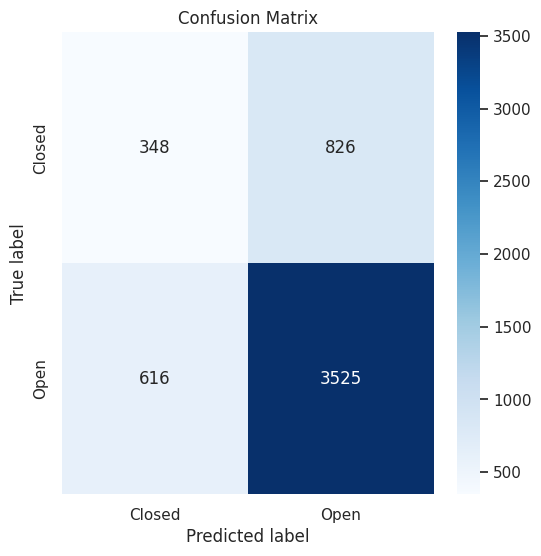

Accuracy: 0.73
Precision: 0.81
Recall: 0.85
F1 Score: 0.83


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# training
rf.fit(X_train_smote, y_train_smote)

# predict
y_pred = rf.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Closed', 'Open'], yticklabels=['Closed', 'Open'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# simple evaluate
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

#Discussion

During the experiment, we had faced some great challenges.

**Complex attribute structure**:

We wanted to use categories as one of the feature, however in our experiment using pyspark, we first need to use stringindex to transform the categories then use the one-hot encoder to wrap and convert it to a machine learning favourite feature; after that it took a long time to fit the model; we then tried to add categories to the DataFrame experiment, but the RAM couldn't handle it, and the session crashed. which we are continuing to work on fixing.

**Future work**:

From our experiments, we have now demonstrated the effectiveness of SMOTE, achieving acceptable recall and precision on the prediction of is_open. We will first continue using pandas DataFrame to find the model and parameters that perform the best in terms of recall and precision. Then, we can apply the same method using PySpark to achieve our original goal.
